In [8]:
import cv2
import matplotlib.pyplot as plt


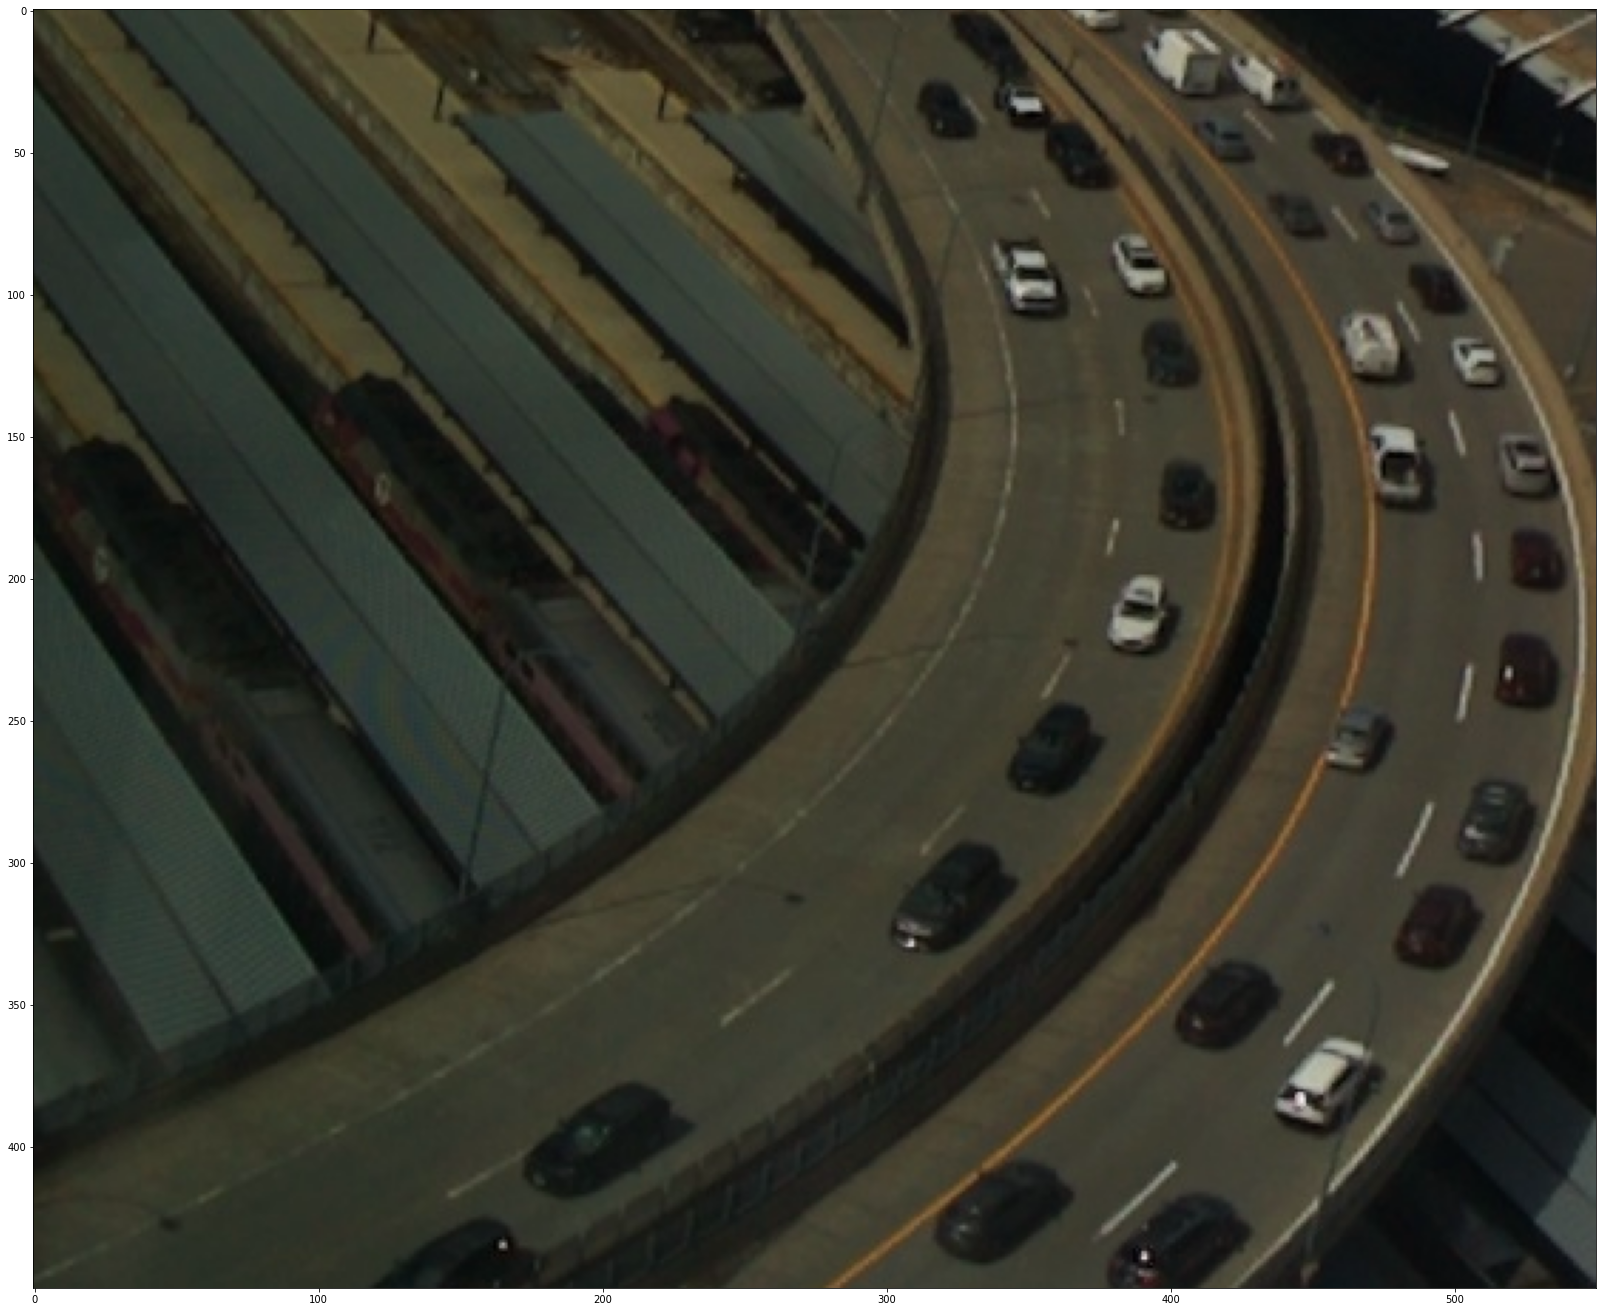

In [24]:


path = 'frames_1744829331345/1744829334144.jpg'

# Load the image (OpenCV loads as BGR by default)
img_bgr = cv2.imread(path)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Show the image (still shown as BGR unless you use a custom viewer)
img_bgr = img_bgr[600:1050,250:800]
plt.figure(figsize=(28, 26))
plt.imshow(img_bgr)
plt.show()


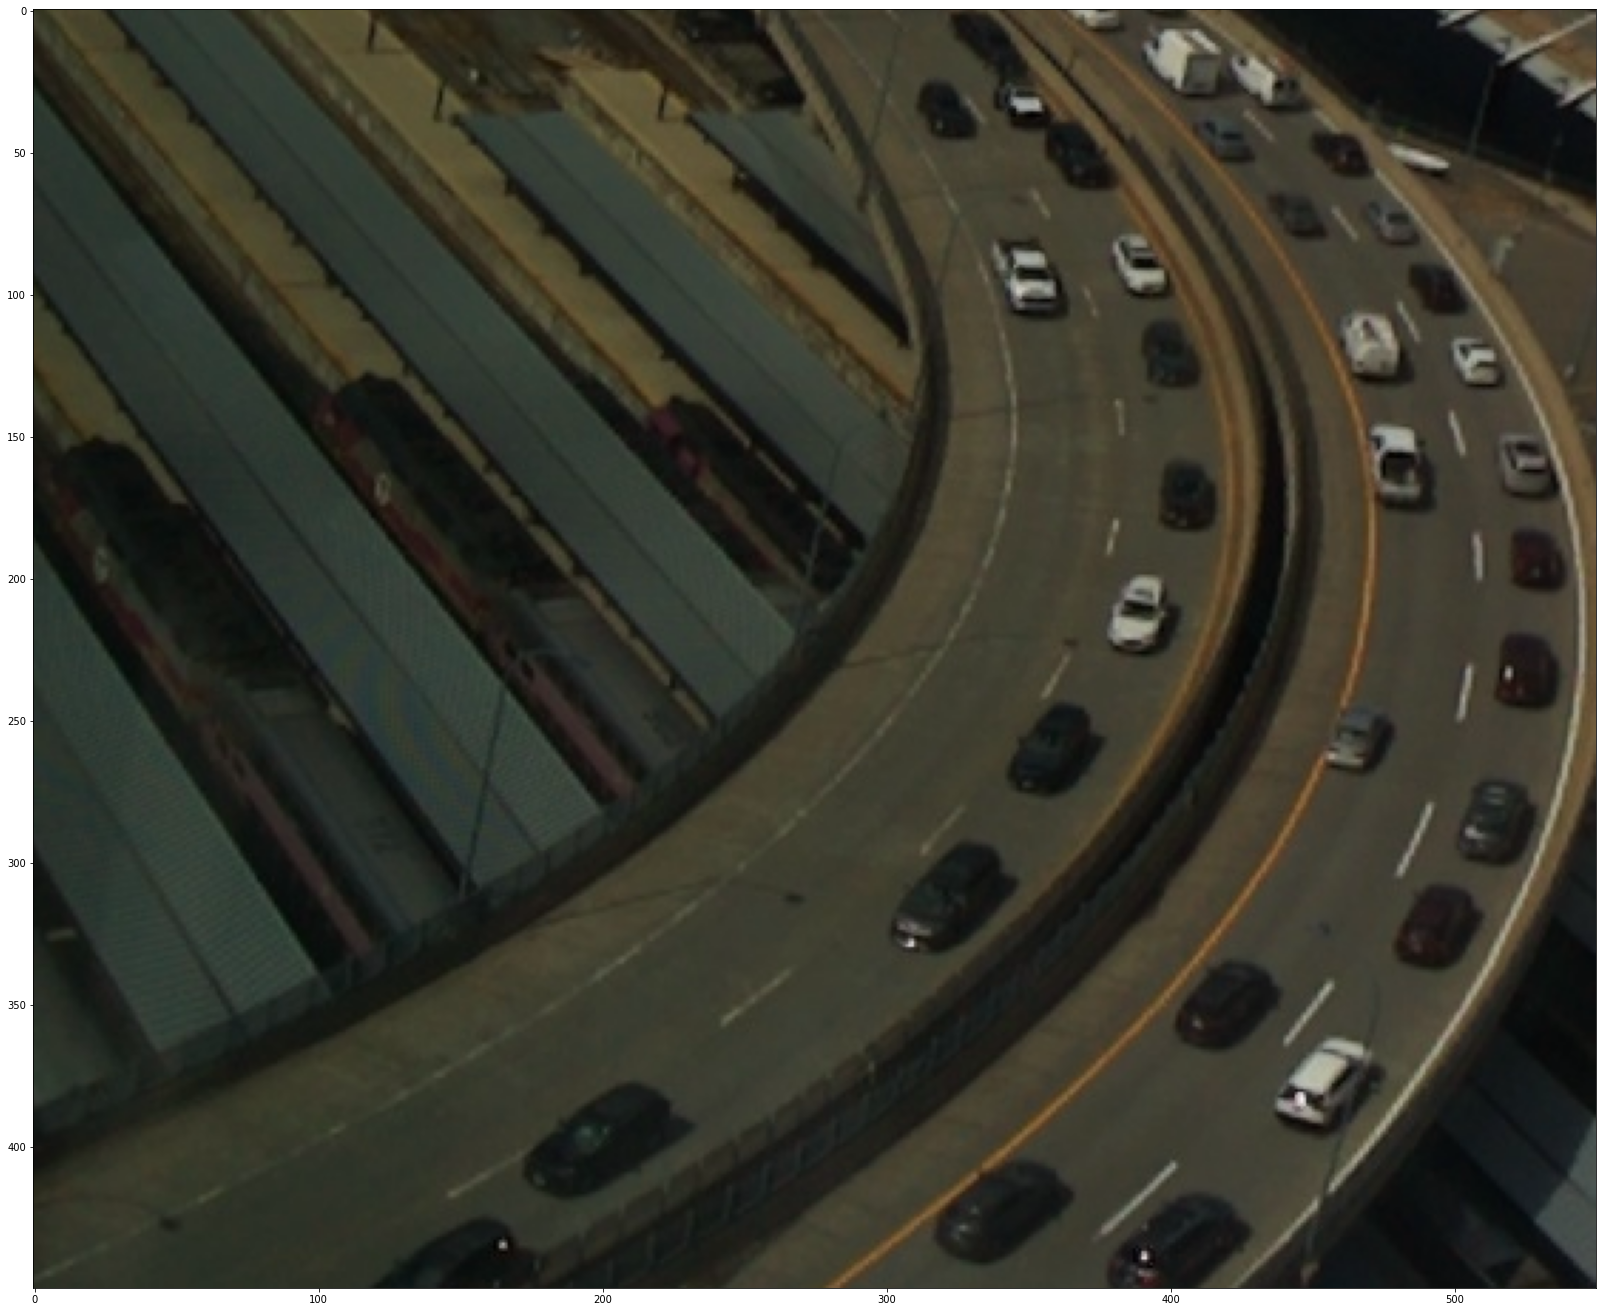

In [25]:
import os
import glob

import cv2
import torch
from PIL import Image
from torchvision.transforms import functional as F
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator


if img_bgr is None:
    raise RuntimeError(f"Failed to load image {earliest!r}")

# Convert to RGB PIL for torchvision
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(img_rgb)

# ─── 3) Build small‑object‑friendly Faster R‑CNN ───────────────────────────
backbone = resnet_fpn_backbone('resnet50', pretrained=True)

# Per‑level anchors for P2–P6
sizes = ((16,), (32,), (64,), (128,), (256,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(sizes)
anchor_gen = AnchorGenerator(sizes=sizes, aspect_ratios=aspect_ratios)

model = FasterRCNN(
    backbone,
    num_classes=91,
    rpn_anchor_generator=anchor_gen,
    min_size=1200,
    max_size=2000
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# ─── 4) Run inference ──────────────────────────────────────────────────────
img_tensor = F.to_tensor(img_pil).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(img_tensor)[0]

# ─── 5) Draw ALL detections above a confidence threshold ──────────────────
COCO_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

CONF_THRESH = 0.05

for box, lbl, score in zip(output['boxes'], output['labels'], output['scores']):
    if score.item() < CONF_THRESH:
        continue

    idx = lbl.item()
    # safety check
    if idx >= len(COCO_NAMES):
        cls_name = str(idx)
    else:
        cls_name = COCO_NAMES[idx]

    x1, y1, x2, y2 = map(int, box.tolist())
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(
        img_bgr,
        f"{cls_name} {score:.2f}",
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (255, 255, 255),
        1
    )

plt.figure(figsize=(28, 26))
plt.imshow(img_bgr)
plt.show()


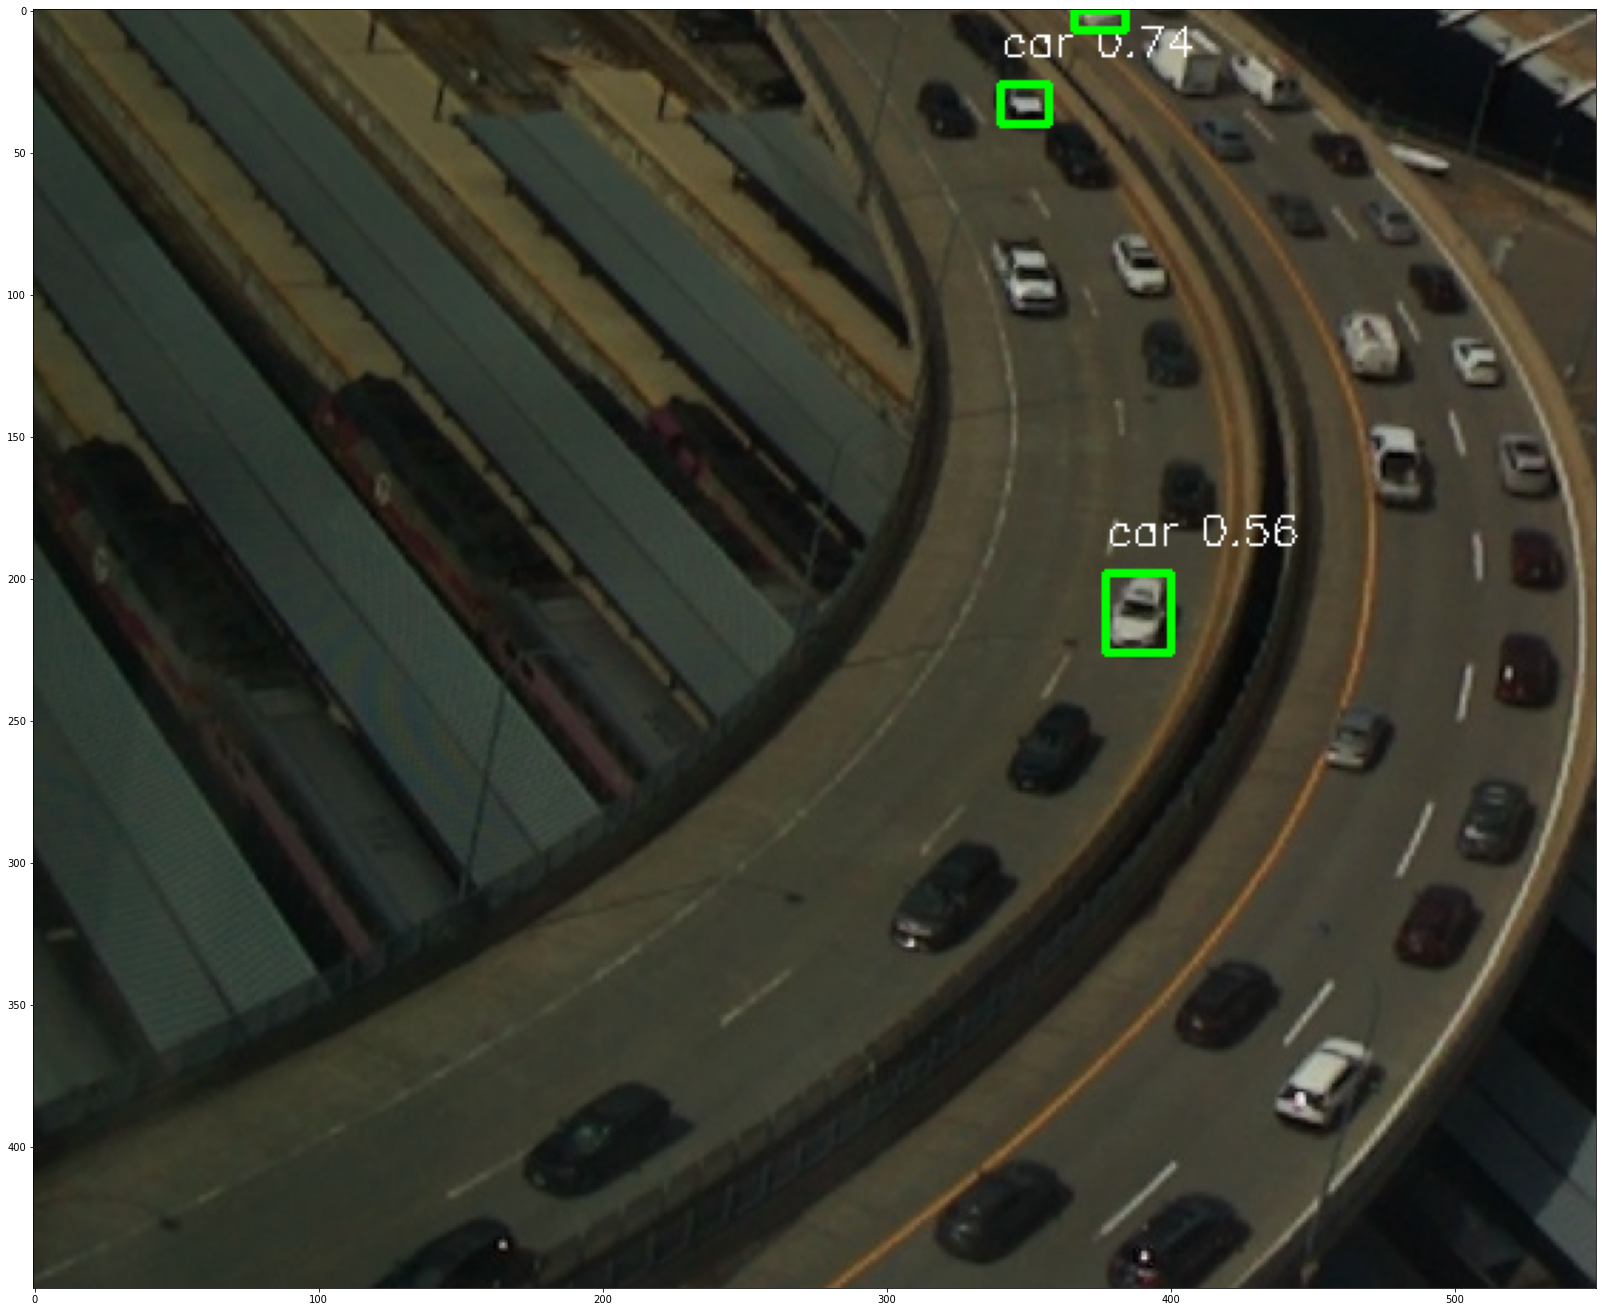

In [13]:
plt.figure(figsize=(28, 26))
plt.imshow(img_bgr)
plt.show()
